In [49]:
import os

import pandas as pd
import numpy as np
import itertools
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# TODO:
# * Short the legend following the color code

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Avenir"
mpl.rcParams['pdf.fonttype'] = 42

mpl.rcParams.update({"pdf.use14corefonts": True})

path_to_scenarios = '/Users/Guille/Desktop/india_power/scenarios'
path_to_images    = '/Users/Guille/Desktop/india_power/images'

In [50]:
scen_labels_ = pd.read_csv('cost_scenario_labels.csv') 
tech_labels_ = pd.read_csv('technology_labels.csv') 

In [51]:
# Grab data from databases for plotting new and existing capacity
def _load_capacity(scen_labels_):

    # Load project capacity table and process them from database
    def __load_new_and_existing_csv(capacity_, projects_, scenario, zone):

        capacity_['capacity_mw'] = capacity_['capacity_mw'].astype(float)
        capacity_['status']      = 'new'
        capacity_                = capacity_[['project', 
                                              'period', 
                                              'technology', 
                                              'load_zone', 
                                              'status', 
                                              'capacity_mw', 
                                              'energy_capacity_mwh']]

        idx_  = (capacity_['period'] == 2020) & (capacity_['capacity_mw'] != 0.)
        capacity_.loc[capacity_['project'].isin(capacity_.loc[idx_, 'project'].unique()), 'status'] = 'existing'
        
        capacity_ = capacity_.groupby(['period', 
                                       'technology', 
                                       'load_zone', 
                                       'status']).agg({'capacity_mw': 'sum', 'energy_capacity_mwh': 'sum'})

        return capacity_.reset_index(drop = False).rename(columns = {'energy_capacity_mwh': 'capacity_mwh'})

    dfs_  = []

    # Open connection: open database and grab meta-data
    for scenario, zone, path in zip(scen_labels_['scenario'], 
                                    scen_labels_['zone'], 
                                    scen_labels_['path']):
        
        dir_name        = r'{}/{}'.format(path, scenario)
        capacity_table_ = pd.read_csv(dir_name + r'/results/project_period.csv', low_memory = False)
        spec_table_     = pd.read_csv(dir_name + r'/inputs/spec_capacity_period_params.tab', sep = '\t', engine = 'python')
        project_table_  = pd.read_csv(dir_name + r'/inputs/projects.tab', sep = '\t', engine = 'python')
        project_table_  = project_table_[project_table_['project'].isin(pd.unique(spec_table_['project']))]
        df_             = __load_new_and_existing_csv(capacity_table_, project_table_, scenario, zone)
        df_['scenario'] = scenario
        # Load specified capacity from csv files
        dfs_.append(df_)

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

def _group_capacity_technologies(capacity_, tech_labels_):

    for group in tech_labels_['group'].unique():
        capacity_.loc[capacity_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
        
    capacity_ = capacity_.groupby(['period', 
                                   'technology', 
                                   'load_zone', 
                                   'status', 
                                   'scenario']).agg({'capacity_mw': 'sum', 'capacity_mwh': 'sum'})

    return capacity_.reset_index(drop = False)

grouped_capacity_ = _group_capacity_technologies(_load_capacity(scen_labels_), tech_labels_)

In [73]:
def _plot_new_and_existing_capacity(df_, scens_label_, tech_label_, units        = 1e3,
                                                                    units_label  = 'Existing & New Capacity (GW)',
                                                                    y_period_loc = -1600.,
                                                                    y_grid_inc   = 500,
                                                                    div_line_len = 0.325,
                                                                    save         = True,
                                                                    legend       = True,
                                                                    title        = '',
                                                                    file_name    = 'noname.pdf'):

    def __make_new_and_existing_capacit_legend(df_, techs_, colors_, ax):

        ax.bar(0., 0., 0., bottom    = 0.,
                           label     = 'Existing',
                           color     = 'None',
                           lw        = 0.,
                           hatch     = 'xx',
                           edgecolor = 'lightgray',
                           zorder    = 10)

        for tech, i_tech in zip(techs_, range(len(techs_))):
            idx_ = df_['technology'] == tech
            if idx_.sum() > 0:
                if df_.loc[idx_, 'capacity_mw'].sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = colors_[i_tech],
                                       label  = tech,
                                       zorder = 10)

    periods_     = np.sort(df_['period'].unique())
    scens_       = scens_label_['scenario'].unique()    
    techs_, idx_ = np.unique(tech_label_['group'], return_index = True)
    colors_      = tech_label_.loc[tech_label_.index[idx_], 'group_color'].to_list()
    
    fig = plt.figure(figsize = (12.5, 10))
    ax  = plt.subplot(111)

    ticks_    = []
    labels_   = []
    offsets_  = []
    lengths_  = []
    x_period_ = []
    
    i_scen = 0
    offset = 0
    y_max  = 0
    
    width  = 1/(len(scens_) + 1)
    x_     = np.linspace(0, len(periods_) - 1, len(periods_))
    
    for scen, label, zone in zip(scens_label_['scenario'], scens_label_['label'], scens_label_['zone']):

        df_p_ = df_.copy()
        
        if (df_p_['load_zone'] == zone).sum() == 0.:
            df_p_['load_zone'] = zone
            df_p_ = df_p_.groupby(['period', 
                                   'technology', 
                                   'load_zone', 
                                   'status',
                                   'scenario']).agg({'capacity_mw': 'sum'}).reset_index(drop = False)
            
        idx_ = (df_p_['scenario'] == scen) & (df_p_['load_zone'] == zone)
                
        for period, i_period in zip(periods_, range(len(periods_))):
            idx_1_ = idx_ & (df_p_['period'] == period)
            if (i_scen == 0) & (i_period == 0): 
                __make_new_and_existing_capacit_legend(df_p_, techs_, colors_, ax)

            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_2_ = idx_1_ & (df_p_['status'] == 'existing') & (df_p_['technology'] == tech)

                if idx_2_.sum() == 1.:
                    power = df_p_.loc[idx_2_, 'capacity_mw'].to_numpy()[0]
                    color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], power/units, width, bottom    = offset/units,
                                                             color     = color,
                                                             lw        = 0.,
                                                             hatch     = 'x',
                                                             edgecolor = 'lightgray', zorder = 10)

                    offset += power

            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_3_ = idx_1_ & (df_p_['technology'] == tech) & (df_p_['status'] == 'new')
                if idx_3_.sum() == 1.:
                    power = df_p_.loc[idx_3_, 'capacity_mw'].to_numpy()[0]
                    color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    ax.bar(x_[i_period], power/units, width, bottom = offset/units,
                                                             color  = color,
                                                             zorder = 10)

                    offset += power

            if y_max < offset:
                y_max = offset

            ticks_.append(x_[i_period])
            labels_.append(label)
            offsets_.append(offset/units)
            x_period_.append(x_[i_period])

            offset = 0.

        x_ = x_ + .9/len(scens_)
        i_scen += 1
        
    z_ = x_ - .9/len(scens_)

    x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
    y_period_ = np.max(np.array(offsets_).reshape(len(scens_), len(periods_)), axis = 0)
    
    for x_period, y_period, period in zip(x_period_, y_period_, periods_):
        plt.text(x_period, y_period_loc, period, fontsize            = 18, 
                                                 weight              = 'bold',
                                                 horizontalalignment = 'center', 
                                                 verticalalignment   = 'center')

    x_ = np.linspace(0, len(periods_), len(periods_) + 1)
    dz = (x_[1] - z_[0])
    for x in x_:
        ax.axvline(x - dz/2., ymin      = 0.,
                              ymax      = - div_line_len,
                              linewidth = .75,
                              linestyle = '-',
                              color     = 'k',
                              clip_on   = False,
                              zorder    = 10)

    N_steps  = int(np.ceil((y_max/units)/y_grid_inc))
    y_ticks_ = np.linspace(0, int(N_steps*y_grid_inc), N_steps + 1, dtype = int)

    ax.set_xticks(ticks_, labels_, rotation = 90)

    ax.xaxis.set_tick_params(labelsize = 12, 
                             left      = False)
    
    ax.yaxis.set_tick_params(labelsize = 12, 
                             left      = False)

    ax.set_ylabel(units_label, fontsize = 18)
    ax.set_yticks(y_ticks_, y_ticks_)

    if legend:
        ax.legend(loc            = 'center left',
                  bbox_to_anchor = (1, 0.5),
                  frameon        = False,
                  prop           = {'size': 12})

    plt.ylim(-10., y_period_.max()*1.2)

    plt.title(title, fontsize = 20,
                     y        = 0.912)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    plt.grid(axis = 'y')

    if save:
        plt.savefig(file_name, bbox_inches = 'tight', 
                               dpi         = 600)
        plt.show()


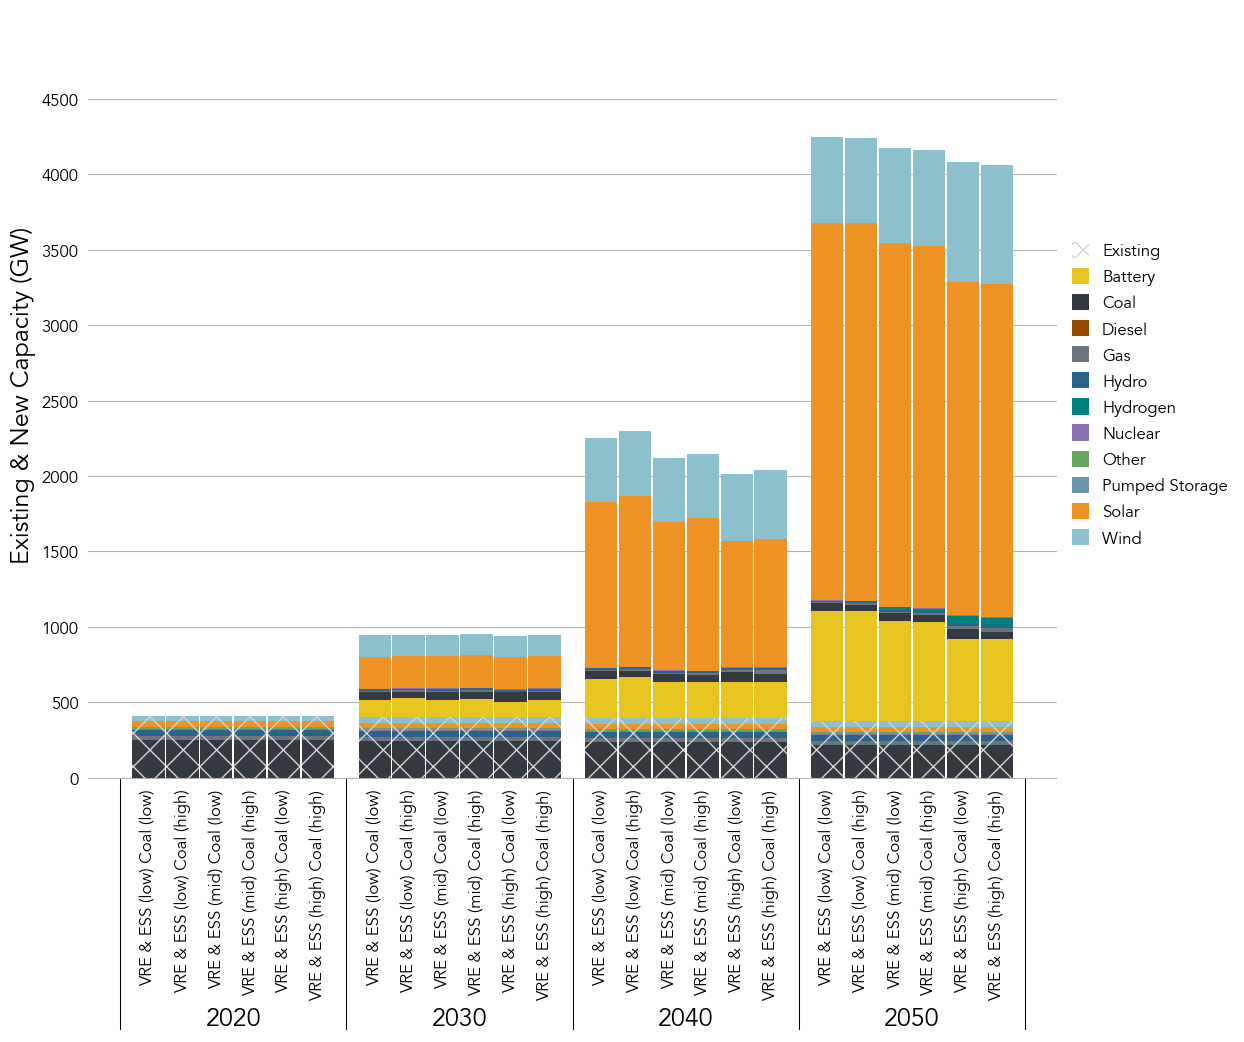

In [74]:
_plot_new_and_existing_capacity(grouped_capacity_, scen_labels_, tech_labels_,
                                units_label = 'Existing & New Capacity (GW)',
                                file_name   = path_to_images + r'/group_installed_capacity.png')

In [43]:
# Grab data from databases for plotting energy dispatch and clean energy targets
def _load_dispatch(scen_labels_):

    # Load energy dispatch table and process data from database
    def __load_dispatch_from_csv(df_, scenario, zone):
        
        df_['power_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['power_mw']

        df_ = df_[['period', 'technology', 'load_zone', 'power_mw']]
            
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)
        
        df_['scenario'] = scenario
                
        return df_
        
    # Load energy dispatch table and process data from database
    def __load_demand_from_csv(df_, scenario, zone):
        
        df_['overgeneration_mw']  = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['overgeneration_mw']
        df_['unserved_energy_mw'] = df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['unserved_energy_mw']
        
        df_1_               = df_[['period', 'load_zone', 'overgeneration_mw']].copy()
        df_1_['technology'] = 'Curtailment'                
        df_1_               = df_1_.rename(columns = {'overgeneration_mw': 'power_mw'})

        df_2_               = df_[['period', 'load_zone', 'unserved_energy_mw']].copy()
        df_2_['technology'] = 'Shedding'                 
        df_2_               = df_2_.rename(columns = {'unserved_energy_mw': 'power_mw'})

        df_ = pd.concat([df_1_, df_2_], axis = 0)
            
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)
        
        df_['scenario'] = scenario
                                  
        return df_

    def __load_tx_losses_from_csv(df_, scenario, zone):
        
        df_['transmission_losses_lz_to']   = - df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_losses_lz_to'] 
        df_['transmission_losses_lz_from'] = - df_['number_of_hours_in_timepoint']*df_['timepoint_weight']*df_['transmission_losses_lz_from']

        df_1_               = df_[['period', 'load_zone_to', 'transmission_losses_lz_to']].copy()
        df_1_['technology'] = 'Tx_Losses'
        df_1_               = df_1_.rename(columns = {'transmission_losses_lz_to': 'power_mw', 
                                                      'load_zone_to': 'load_zone'})

        df_2_               = df_[['period', 'load_zone_from', 'transmission_losses_lz_from']].copy()
        df_2_['technology'] = 'Tx_Losses'
        df_2_               = df_2_.rename(columns = {'transmission_losses_lz_from': 'power_mw',
                                                      'load_zone_from': 'load_zone'})
        
        df_ = pd.concat([df_1_, df_2_], axis = 0)
        
        df_ = df_.groupby(['period', 
                           'technology', 
                           'load_zone']).agg({'power_mw': 'sum'}).reset_index(drop = False)

        df_['scenario'] = scenario
        
        return df_

    dfs_ = []
    # Open connection: open database and grab meta-data
    for scenario, zone, path in zip(scen_labels_['scenario'], scen_labels_['zone'], scen_labels_['path']):
        print(scenario, zone, path)
        
        dir_name   = r'{}/{}'.format(path, scenario)
        dispatch_  = pd.read_csv(dir_name + f'/results/project_timepoint.csv', low_memory = False)
        demand_    = pd.read_csv(dir_name + f'/results/system_load_zone_timepoint.csv', low_memory = False)
        tx_losses_ = pd.read_csv(dir_name + f'/results/transmission_timepoint.csv', low_memory = False)
        
        dfs_ += [__load_tx_losses_from_csv(tx_losses_, scenario, zone)]
        dfs_ += [__load_demand_from_csv(demand_, scenario, zone)]
        dfs_ += [__load_dispatch_from_csv(dispatch_, scenario, zone)]

    return pd.concat(dfs_, axis = 0).reset_index(drop = True)

def _group_dispatch_technologies(df_, tech_labels_):

    for group in tech_labels_['group'].unique():
        df_.loc[df_['technology'].isin(tech_labels_.loc[tech_labels_['group'] == group, 'technology']), 'technology'] = group
        
    df_ = df_.groupby(['period', 
                       'technology', 
                       'load_zone', 
                       'scenario']).agg({'power_mw': 'sum'})

    return df_.reset_index(drop = False)

grouped_dispatch_ = _group_dispatch_technologies(_load_dispatch(scen_labels_), tech_labels_)

VRElow_STlow_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost
VRElow_STlow_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost
VREmid_STmid_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVmid_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost
VREhigh_SThigh_CONVhigh_H2_RES_10PRM_CC_50RPS_90CAP_500GW_PIERmid all /Users/Guille/Desktop/india_power/scenarios/cost


In [61]:
def _plot_dispatch(df_, scens_label_, tech_label_, units        = 1e6,
                                                   units_label  = r'Electricity Generation (TWh)',
                                                   y_period_loc = -3870.,
                                                   y_grid_inc   = 1000,
                                                   div_line_len = .425,
                                                   save         = True,
                                                   legend       = True,
                                                   title        = '',
                                                   file_name    = 'noname.pdf'):

    def __make_dispatch_legend(data_, techs_, colors_, ax):
        for tech, i_tech in zip(techs_, range(len(techs_))):
            idx_ = data_['technology'] == tech
            if idx_.sum() > 0:
                if data_.loc[idx_, 'power_mw'].to_numpy().sum() != 0:
                    ax.bar(0., 0., 0., bottom = 0.,
                                       color  = colors_[i_tech],
                                       label  = tech.replace('_', ' '),
                                       zorder = 2,
                                       ec     = 'None',
                                       lw     = 0.,
                                       aa     = True)

    periods_     = np.sort(df_['period'].unique())
    scens_       = scens_label_['scenario'].unique()    
    techs_, idx_ = np.unique(tech_label_['group'], return_index = True)
    colors_      = tech_label_.loc[tech_label_.index[idx_], 'group_color'].to_list()

    width = 1./(len(scens_) + 1)
    x_    = np.linspace(0, len(periods_) - 1, len(periods_))

    fig = plt.figure(figsize = (12.5, 7.5))
    ax  = plt.subplot(111)

    ticks_    = []
    labels_   = []
    x_period_ = []
    y_period_ = []
    
    i_scen          = 0
    offset_positive = 0.
    offset_negative = 0.    
    y_max           = 0
    y_min           = 0
    
    for scen, label, zone in zip(scens_label_['scenario'], scens_label_['label'], scens_label_['zone']):
        df_p_ = df_.copy()
        
        if (df_p_['load_zone'] == zone).sum() == 0.:
            df_p_['load_zone'] = zone
            df_p_ = df_p_.groupby(['period', 
                                   'technology', 
                                   'load_zone', 
                                    'scenario']).agg({'power_mw': 'sum'}).reset_index(drop = False)
            
        idx_ = (df_p_['scenario'] == scen) & (df_p_['load_zone'] == zone)

        for period, i_period in zip(periods_, range(len(periods_))):
            idx_1_ = idx_ & (df_p_['period'] == period)
            
            if (i_scen == 0) & (i_period == 0): 
                __make_dispatch_legend(df_p_, techs_, colors_, ax)

                
            for tech, i_tech in zip(techs_, range(len(techs_))):
                idx_2_ = idx_1_ & (df_p_['technology'] == tech)

                if idx_2_.sum() == 1:
                    power = float(df_p_.loc[idx_2_, 'power_mw'].to_numpy()[0])
                    color = tech_label_.loc[tech_label_['group'] == tech, 'group_color'].unique()

                    if power != 0:
                        if power > 0:
                            offset = offset_positive
                        else:
                            offset = offset_negative

                        ax.bar(x_[i_period], power/units, width, bottom = offset/units,
                                                                 color  = color,
                                                                 zorder = 2,
                                                                 ec     = 'None',
                                                                 lw     = 0.,
                                                                 aa     = True)

                        if power >= 0:
                            offset_positive += power
                        else:
                            offset_negative += power

            if offset_negative/units < y_min: 
                y_min = offset_negative/units
            if offset_positive/units > y_max: 
                y_max = offset_positive/units

            ticks_.append(x_[i_period])
            labels_.append(label)
            x_period_.append(x_[i_period])
            y_period_.append(offset_positive)
            
            offset_positive = 0.
            offset_negative = 0.

        x_ = x_ + .9/len(scens_)
        
        i_scen += 1
        
    z_ = x_ - .9/len(scens_)

    x_period_ = np.mean(np.array(x_period_).reshape(len(scens_), len(periods_)), axis = 0)
    y_period_ = np.max(np.array(y_period_).reshape(len(scens_), len(periods_)), axis = 0)

    for x_period, y_period, period in zip(x_period_, y_period_, periods_):
        plt.text(x_period, y_period_loc, period, fontsize            = 18, 
                                                 weight              = 'bold',
                                                 horizontalalignment = 'center', 
                                                 verticalalignment   = 'center')

    ax.set_xticks(ticks_, labels_, rotation = 90)
    ax.xaxis.set_tick_params(labelsize = 12, left = False)

    N_steps  = int(np.ceil(y_max/y_grid_inc))
    y_ticks_ = np.linspace(0, int(N_steps*y_grid_inc), N_steps + 1, dtype = int)

    ax.set_ylabel(units_label, fontsize = 18)
    ax.set_yticks(y_ticks_, y_ticks_)
    ax.yaxis.set_tick_params(labelsize = 12, left = False)

    x_ = np.linspace(0, len(periods_), len(periods_) + 1)
    dz = (x_[1] - z_[0])
    for x in x_:
        ax.axvline(x - dz/2., ymin      = 0.,
                              ymax      = -div_line_len,
                              linewidth = .75,
                              linestyle = '-',
                              color     = 'k',
                              clip_on   = False,
                              zorder    = 10)

    if legend:
        ax.legend(loc            = 'center left',
                  bbox_to_anchor = (1, 0.5),
                  frameon        = False,
                  prop           = {'size': 12})

    plt.title(title, fontsize = 18,
                     y        = 0.9125)

    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.grid(axis = 'y')

    if save:
        plt.savefig(file_name, bbox_inches = 'tight',
                               dpi         = 600)

    plt.show()

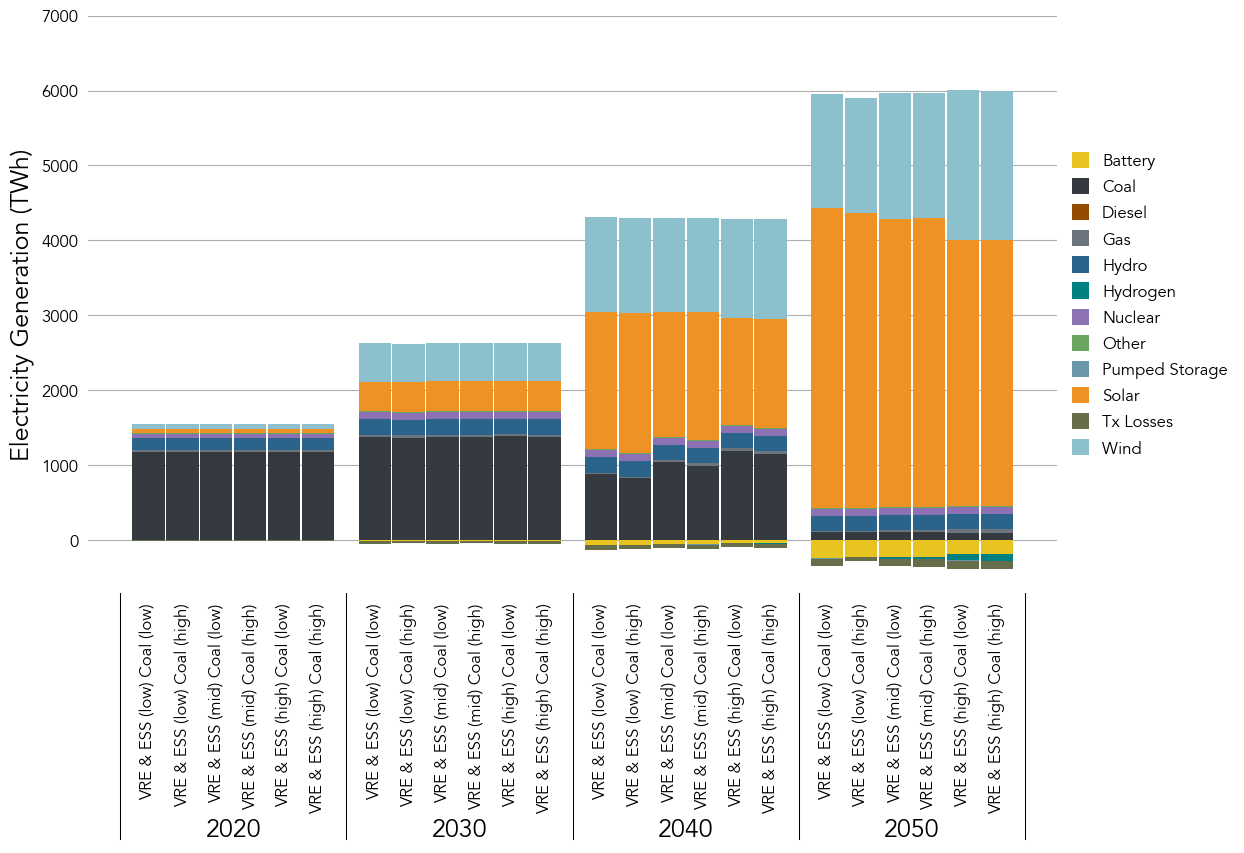

In [62]:
# Enter a title of your choice between the quotation marks ('') under title = ''.
_plot_dispatch(grouped_dispatch_, scen_labels_, tech_labels_, 
               units_label  = r'Electricity Generation (TWh)',
               file_name    = path_to_images + r'/group_electricity_generation.png')